# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data

--2020-10-30 08:52:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.86.17, 54.192.86.125, 54.192.86.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.86.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  77.7MB/s    in 0.6s    

2020-10-30 08:52:23 (77.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/t

## 전처리 설정

In [ ]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [ ]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [ ]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss /  dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Accuracy: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4785	Accuracy: 0.7582
val Loss: 0.2173	Accuracy: 0.9281

Epoch 1/24
----------
train Loss: 0.4346	Accuracy: 0.8238
val Loss: 0.4611	Accuracy: 0.8301

Epoch 2/24
----------
train Loss: 0.6249	Accuracy: 0.7500
val Loss: 0.3954	Accuracy: 0.8235

Epoch 3/24
----------
train Loss: 0.5688	Accuracy: 0.7500
val Loss: 0.3706	Accuracy: 0.8693

Epoch 4/24
----------
train Loss: 0.4756	Accuracy: 0.7992
val Loss: 0.3251	Accuracy: 0.8824

Epoch 5/24
----------
train Loss: 0.6068	Accuracy: 0.7787
val Loss: 0.3057	Accuracy: 0.8824

Epoch 6/24
----------
train Loss: 0.4304	Accuracy: 0.8115
val Loss: 0.3879	Accuracy: 0.8301

Epoch 7/24
----------
train Loss: 0.3288	Accuracy: 0.8320
val Loss: 0.2814	Accuracy: 0.8824

Epoch 8/24
----------
train Loss: 0.2862	Accuracy: 0.8730
val Loss: 0.2604	Accuracy: 0.8824

Epoch 9/24
----------
train Loss: 0.2769	Accuracy: 0.8811
val Loss: 0.2963	Accuracy: 0.8562

Epoch 10/24
----------
train Loss: 0.2965	Accuracy: 0.8648
val Loss: 0

## 결과 시각화

- 시각화 함수 정의

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return

    model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


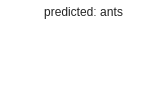

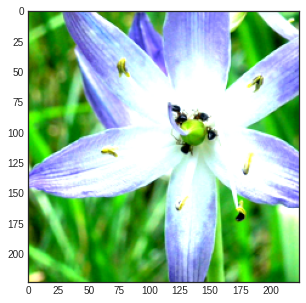

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


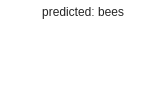

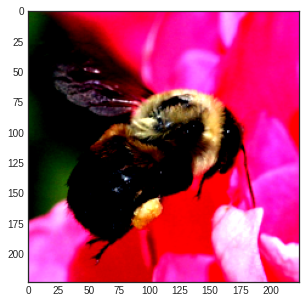

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


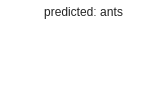

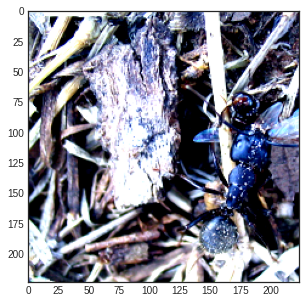

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


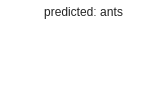

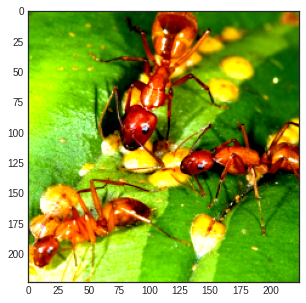

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


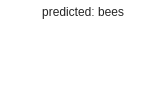

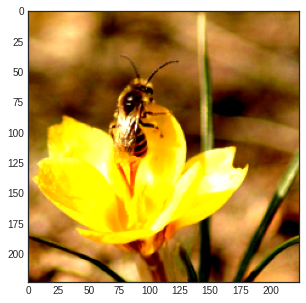

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


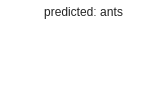

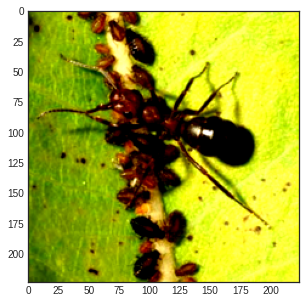

In [ ]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [ ]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5913	Accuracy: 0.7049
val Loss: 0.2542	Accuracy: 0.9412

Epoch 1/24
----------
train Loss: 0.3954	Accuracy: 0.8074
val Loss: 0.2157	Accuracy: 0.9085

Epoch 2/24
----------
train Loss: 0.4053	Accuracy: 0.8197
val Loss: 0.1994	Accuracy: 0.9216

Epoch 3/24
----------
train Loss: 0.3588	Accuracy: 0.8279
val Loss: 0.3595	Accuracy: 0.8497

Epoch 4/24
----------
train Loss: 0.5833	Accuracy: 0.7254
val Loss: 0.3315	Accuracy: 0.8627

Epoch 5/24
----------
train Loss: 0.3574	Accuracy: 0.8525
val Loss: 0.1710	Accuracy: 0.9412

Epoch 6/24
----------
train Loss: 0.3467	Accuracy: 0.8648
val Loss: 0.1718	Accuracy: 0.9608

Epoch 7/24
----------
train Loss: 0.4064	Accuracy: 0.8279
val Loss: 0.2032	Accuracy: 0.9477

Epoch 8/24
----------
train Loss: 0.2913	Accuracy: 0.8730
val Loss: 0.1938	Accuracy: 0.9412

Epoch 9/24
----------
train Loss: 0.3006	Accuracy: 0.8893
val Loss: 0.2140	Accuracy: 0.9085

Epoch 10/24
----------
train Loss: 0.3736	Accuracy: 0.8361
val Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


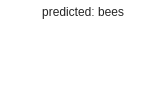

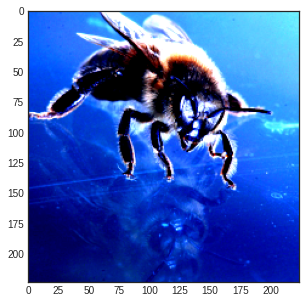

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


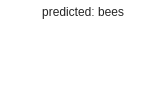

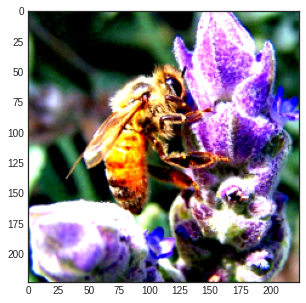

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


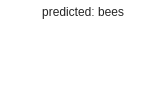

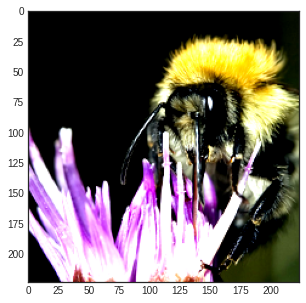

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


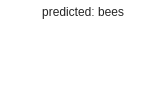

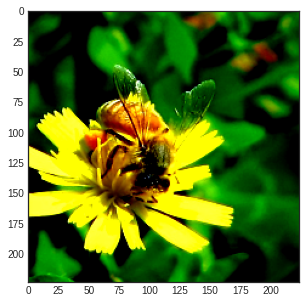

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


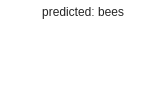

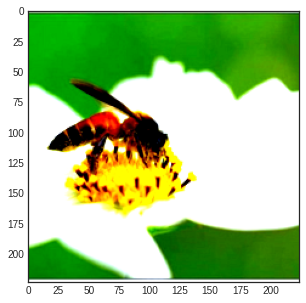

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


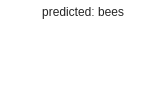

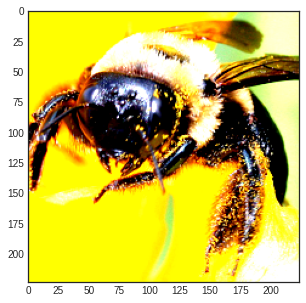

In [ ]:
visualize_model(model_conv)